# Time Series Analysis

### Initial filtering and subsetting

In [2]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.color_palette("coolwarm")
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

In [3]:
#Loading CSV files to access data
df_stores = pd.read_csv('../data/stores.csv')
df_items = pd.read_csv('../data/items.csv')
df_transactions = pd.read_csv('../data/transactions.csv')
df_oil = pd.read_csv('../data/oil.csv')
df_holidays_events = pd.read_csv('../data/holidays_events.csv')

In [8]:
#Loading train csv but with limited rows due to file size
df_train = pd.read_csv('../data/train.csv', nrows=2000000)

In [9]:
#Selecting stores located in the 'Guayas' region
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

In [10]:
#Presetting dtypes to prevent errors during csv reading
dtypes = {
    'id': 'int64',
    'date': 'object',
    'store_nbr': 'int64',
    'item_nbr': 'int64',
    'unit_sales': 'float64',
    'onpromotion': 'object'
}

In [11]:
#Initialising an empty list to hold filtered chunks
filtered_chunks = []
#Defining the chunk size
chunk_size = 500000

In [12]:
#Reading the CSV file in chunks
csv_path = '../data/train.csv'
for chunk in pd.read_csv(csv_path, chunksize=chunk_size, dtype=dtypes):
    #Filter the chunk immediately
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)].copy()

    #Append to list
    filtered_chunks.append(chunk_filtered)

    #Cleanup
    del chunk, chunk_filtered

#Concatenating all filtered chunks into a single DataFrame
df_train_guayas = pd.concat(filtered_chunks, ignore_index=True)

#Final cleanup
del filtered_chunks

In [13]:
#Checking size
df_train_guayas.shape

(22941656, 6)

Additionally, I will be filtering the 'items.csv' data in 'df_train_guayas' to only include the top 3 families (product categories) by the number of items.

In [14]:
#Checking Family item counts
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
items_per_family.head(10)

,Family,Item Count
0,GROCERY I,1334
1,BEVERAGES,613
2,CLEANING,446
3,PRODUCE,306
4,DAIRY,242
5,PERSONAL CARE,153
6,BREAD/BAKERY,134
7,HOME CARE,108
8,DELI,91
9,MEATS,84


In [15]:
#Filtering by top 3 Families
top_3_families = items_per_family.head(3)

item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].unique()
df_ts = df_train_guayas[df_train_guayas['item_nbr'].isin(item_ids)]

In [16]:
#Checking shape again after filtering
df_ts.shape

(14745768, 6)

#### Checkpoint

In [17]:
#Saving a checkpoint after filtering
df_ts.to_parquet("/Users/dan/PycharmProjects/Masterschool/TimeSeriesRetailForecast/data/df_ts_checkpoint1.parquet")
print("Checkpoint 1 saved successfully!")

Checkpoint 1 saved successfully!


In [6]:
df_ts = pd.read_parquet("/Users/dan/PycharmProjects/Masterschool/TimeSeriesRetailForecast//data/df_ts_checkpoint1.parquet")

### Basic cleaning

In [18]:
#Checking the top lines of the primary dataframe
df_ts.head(10)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
1,18790,2013-01-02,24,105574,12.00,NaN
2,18791,2013-01-02,24,105575,2.00,NaN
3,18792,2013-01-02,24,105577,1.00,NaN
4,18793,2013-01-02,24,105693,7.00,NaN
5,18794,2013-01-02,24,105737,17.00,NaN
6,18795,2013-01-02,24,105857,1.00,NaN
7,18796,2013-01-02,24,106716,3.00,NaN
10,18799,2013-01-02,24,108786,3.00,NaN
11,18800,2013-01-02,24,108797,2.00,NaN
13,18802,2013-01-02,24,108862,3.00,NaN


In [19]:
#Checking data types
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14745768 entries, 1 to 22941654
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   item_nbr     int64  
 4   unit_sales   float64
 5   onpromotion  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 787.5+ MB


In [20]:
#Checking mid-points and variance in 'unit_sales'
df_ts["unit_sales"].describe(percentiles=(0.01, 0.05, 0.95, 0.99))

count   14,745,768.00
mean             6.81
std             18.90
min        -10,002.00
1%               1.00
5%               1.00
50%              3.00
95%             23.00
99%             57.00
max         17,146.00
Name: unit_sales, dtype: float64

'unit_sales' includes negative values (product returns). Values also reveal heavy right-tail behaviour with max 3 orders of magnitude higher than the median.

In [21]:
#Checking how many unit_sales are negative
negative_sales_train = df_ts[df_ts['unit_sales'] < 0]
negative_sales_train.shape

(794, 6)

In [22]:
#Filling negative unit sales with 0 to represent no sale
df_ts = df_ts.copy()
df_ts["unit_sales"] = df_ts["unit_sales"].clip(lower=0)

In [23]:
#Checking null value counts for 'onpromotion'
df_ts["onpromotion"].isnull().sum()

2747275

In [24]:
#Checking values in onpromotion column
df_ts["onpromotion"].value_counts()

onpromotion
False    11319196
True       679297
Name: count, dtype: int64

In [25]:
#Converting 'onpromotion' to Bool
df_ts['onpromotion'] = df_ts['onpromotion'].map({'True': True, 'False': False})

#Replacing missing values with False
df_ts['onpromotion'] = df_ts['onpromotion'].fillna(False)

/var/folders/2v/m_x7n7fs78d907pmmk92pbmm0000gn/T/ipykernel_18868/1317307128.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ts['onpromotion'] = df_ts['onpromotion'].fillna(False)


In [26]:
#Converting onpromotion to 0 = False, 1 = True
df_ts['onpromotion'] = df_ts['onpromotion'].astype(int)
df_ts["onpromotion"].value_counts()

onpromotion
0    14066471
1      679297
Name: count, dtype: int64

##### Applying full date range and filling missing days

In [27]:
#Getting min and max dates to create a full date range
min_date = df_ts["date"].min()
max_date = df_ts["date"].max()

#Getting full date range
full_date_range = pd.DataFrame({"date": pd.date_range(min_date, max_date, freq="D")})

In [28]:
#Creating a df with all (store, item, date) columns
store_item_combinations = df_ts[["store_nbr", "item_nbr"]].drop_duplicates()
all_combinations = store_item_combinations.merge(full_date_range, how="cross")

In [29]:
#Updating date column to datetime type
all_combinations['date'] = pd.to_datetime(all_combinations['date'])
df_ts['date'] = pd.to_datetime(df_ts['date'])

In [30]:
#Merging with primary dataframe to fill missing values
df_ts = all_combinations.merge(df_ts, on=["store_nbr", "item_nbr", "date"], how="left")

In [31]:
#Doubel checking dtypes and columns
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35069356 entries, 0 to 35069355
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   store_nbr    int64         
 1   item_nbr     int64         
 2   date         datetime64[ns]
 3   id           float64       
 4   unit_sales   float64       
 5   onpromotion  float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 1.6 GB


In [33]:
#Dropping id column as not needed for EDA or modelling
df_ts = df_ts.drop(columns="id")

#### Checkpoint

In [34]:
#Saving a checkpoint after merging
df_ts.to_parquet("/Users/dan/PycharmProjects/Masterschool/TimeSeriesRetailForecast/data/df_ts_checkpoint2.parquet")
print("Checkpoint 2 saved successfully!")

Checkpoint 2 saved successfully!


In [5]:
df_ts = pd.read_parquet("/Users/dan/PycharmProjects/Masterschool/TimeSeriesRetailForecast//data/df_ts_checkpoint2.parquet")

### Raw EDA

#### Train

In [35]:
df_ts.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion
0,24,105574,2013-01-02,12.00,0.00
1,24,105574,2013-01-03,1.00,0.00
2,24,105574,2013-01-04,3.00,0.00
3,24,105574,2013-01-05,4.00,0.00
4,24,105574,2013-01-06,7.00,0.00


In [36]:
#Checking how many unique stores we have after filtering
df_ts["store_nbr"].nunique()

11

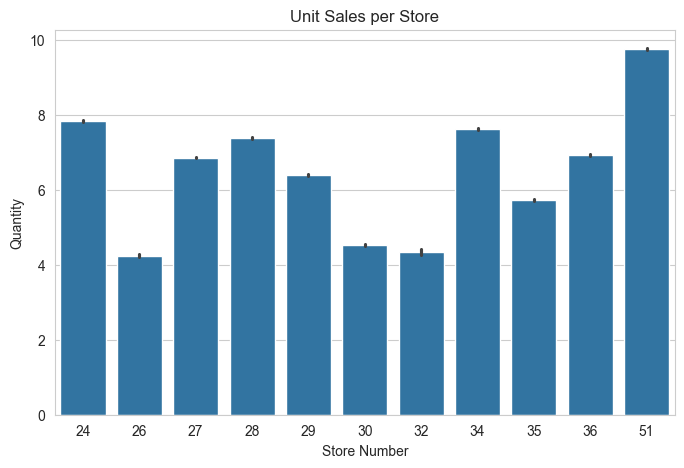

In [37]:
#Plotting Unit Sales by Store Number to understand differences in scale
sns.set_style("whitegrid")
sns.color_palette("coolwarm")

plt.figure(figsize=(8, 5))
sns.barplot(df_ts, x="store_nbr", y="unit_sales")
plt.title("Unit Sales per Store")
plt.xlabel("Store Number")
plt.ylabel("Quantity")
plt.show()

In [38]:
#Recording store numbers
guayas_store_nbr = {24, 26, 27, 28, 29, 30, 32, 34, 35, 36, 51}

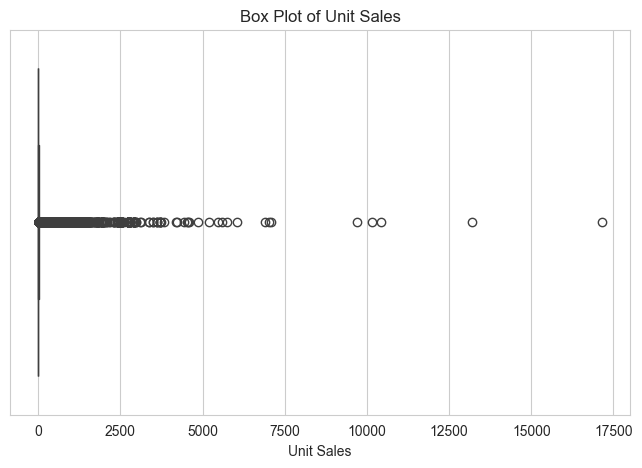

In [39]:
#Plotting Unit Sales to see scale of distribution
plt.figure(figsize=(8, 5))
sns.boxplot(df_ts, x="unit_sales")
plt.title("Box Plot of Unit Sales")
plt.xlabel("Unit Sales")
plt.show()

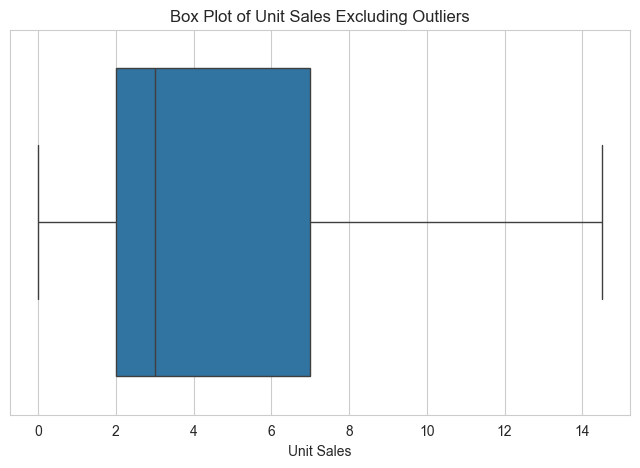

In [40]:
#Plotting again but without outliers to explore mean and variance
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_ts["unit_sales"], showfliers=False)
plt.title("Box Plot of Unit Sales Excluding Outliers")
plt.xlabel("Unit Sales")
plt.show()

There are some significant outliers in unit_sales (our target for forecasting) so log transformation will be necessary.

#### Stores

In [41]:
#Focusing only on Guayas region as per earlier filtering in train df
df_stores_guayas = df_stores[df_stores['state'] == 'Guayas']
df_stores_guayas.head()

,store_nbr,city,state,type,cluster
23,24,Guayaquil,Guayas,D,1
25,26,Guayaquil,Guayas,D,10
26,27,Daule,Guayas,D,1
27,28,Guayaquil,Guayas,E,10
28,29,Guayaquil,Guayas,E,10


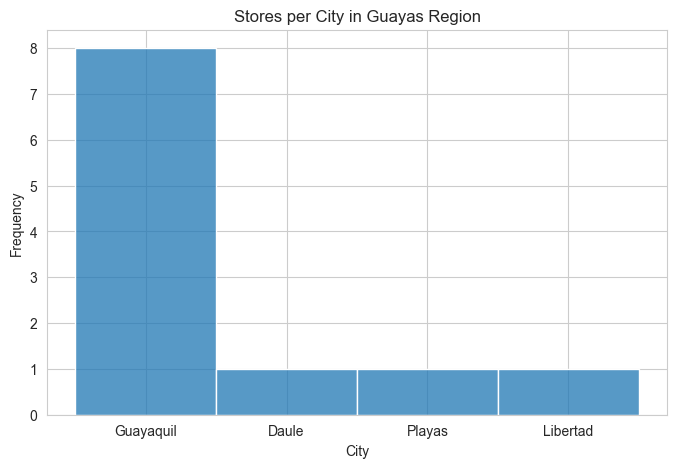

In [42]:
#Plotting Stores per City to understand distribution
plt.figure(figsize=(8, 5))

sns.histplot(df_stores_guayas, x="city")
plt.title("Stores per City in Guayas Region")
plt.xlabel("City")
plt.ylabel("Frequency")
plt.show()

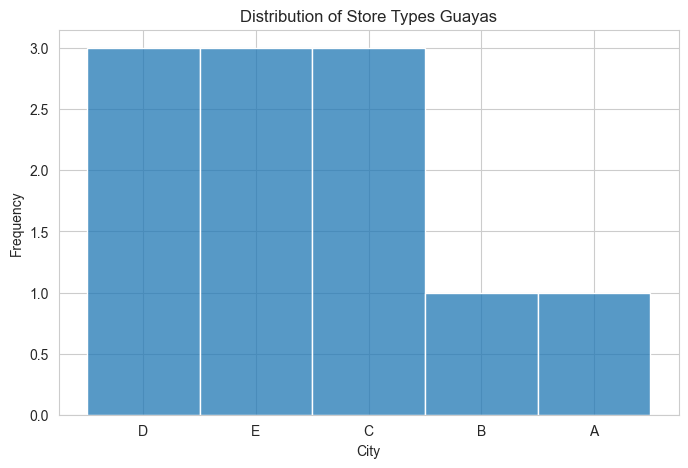

In [43]:
#Plotting Store Type to understand distribution
plt.figure(figsize=(8, 5))

sns.histplot(df_stores_guayas, x="type")
plt.title("Distribution of Store Types Guayas")
plt.xlabel("City")
plt.ylabel("Frequency")
plt.show()

#### Items

In [44]:
#Filtering items to only include the top families (as per our earlier filtering)
df_items_top = df_items[df_items["family"].isin(["GROCERY I", "BEVERAGES", "CLEANING"])].copy()

In [45]:
df_items_top.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
5,105574,GROCERY I,1045,0


In [46]:
#Checking for null values
df_items.isnull().sum()

item_nbr      0
family        0
class         0
perishable    0
dtype: int64

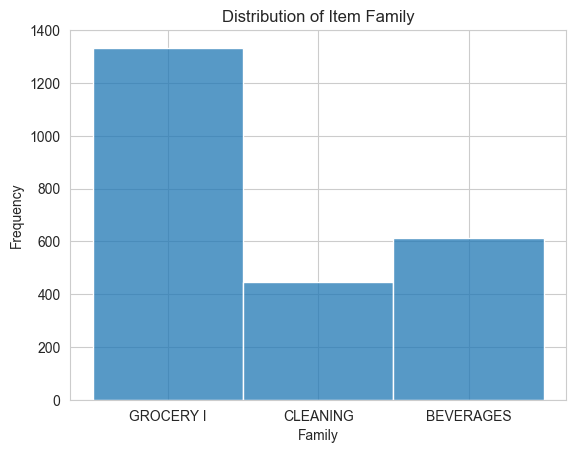

In [47]:
#Plotting item family by frequency
sns.histplot(df_items_top, x="family")
plt.title("Distribution of Item Family")
plt.xlabel("Family")
plt.ylabel("Frequency")
plt.show()

In [48]:
#Checking value counts for perishable feature
df_items_top["perishable"].value_counts()

perishable
0    2393
Name: count, dtype: int64

Missing perishable values will need filling during data prep

#### Transactions

In [49]:
#Filtering data by stores in Guayas region
mask = df_transactions["store_nbr"].isin(guayas_store_nbr)
df_transactions_guayas = df_transactions[mask]
df_transactions_guayas.head()

,date,store_nbr,transactions
21,2013-01-02,24,2605
23,2013-01-02,26,1008
24,2013-01-02,27,1386
25,2013-01-02,28,950
26,2013-01-02,30,708


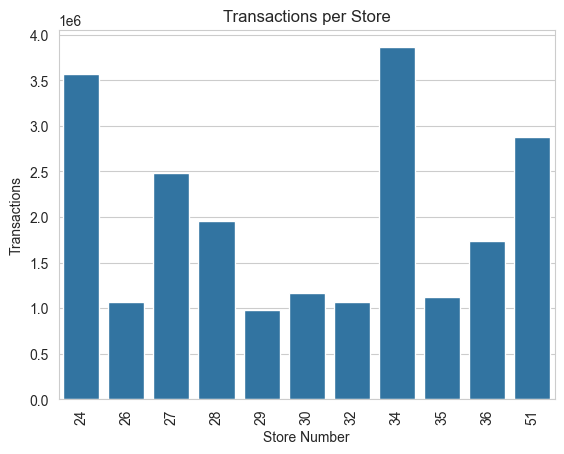

In [50]:
#Plotting transactions by store number to understand distribution
df_store_transactions = df_transactions_guayas.groupby("store_nbr")["transactions"].sum().reset_index()

sns.barplot(df_store_transactions, y="transactions", x="store_nbr")
plt.title("Transactions per Store")
plt.xlabel("Store Number")
plt.ylabel("Transactions")
plt.xticks(rotation=90)
plt.show()

#### Oil

In [51]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [52]:
#Checking data types
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [53]:
#Checking mid-points and variance
df_oil.describe()

,dcoilwtico
count,"1,175.00"
mean,67.71
std,25.63
min,26.19
25%,46.41
50%,53.19
75%,95.66
max,110.62


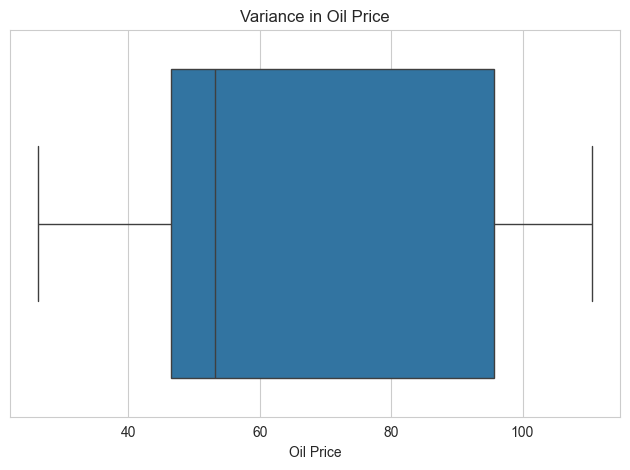

In [54]:
#Plotting oil price variance
sns.boxplot(df_oil, x="dcoilwtico")
plt.title("Variance in Oil Price")
plt.xlabel("Oil Price")
plt.tight_layout()
plt.show()

In [55]:
#Converting date from object to datetime
df_oil['date'] = pd.to_datetime(df_oil['date'])

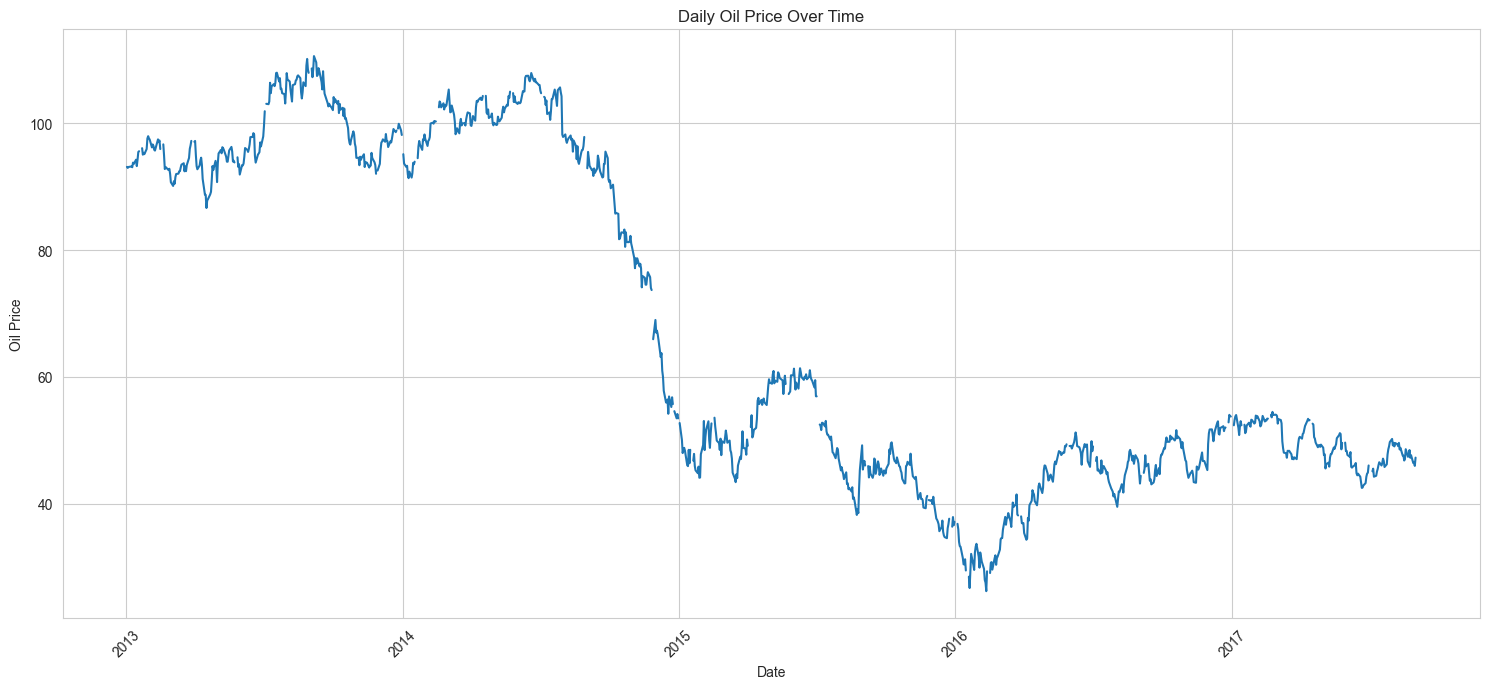

In [56]:
#Plotting oil price as a time-series
oil_by_date = df_oil.groupby('date')['dcoilwtico'].mean()

plt.figure(figsize=(15,7))
plt.plot(oil_by_date.index, oil_by_date.values)
plt.title('Daily Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [57]:
#Creating rolling averages for observation
rolling_avg_7d = oil_by_date.rolling(window=7).mean()
rolling_avg_30d = oil_by_date.rolling(window=30).mean()

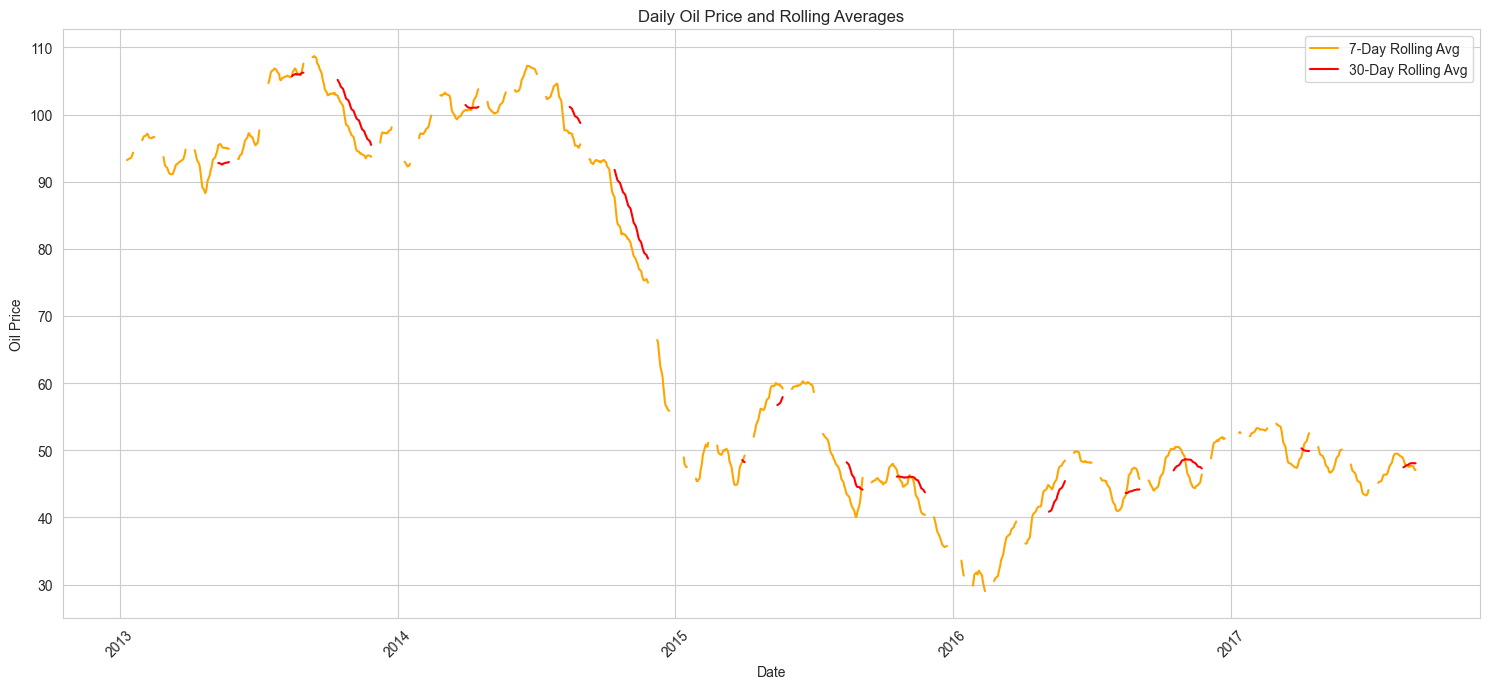

In [58]:
#Plotting rolling averages
plt.figure(figsize=(15, 7))

plt.plot(rolling_avg_7d.index, rolling_avg_7d.values, label='7-Day Rolling Avg', color='orange')
plt.plot(rolling_avg_30d.index, rolling_avg_30d.values, label='30-Day Rolling Avg', color='red')

plt.title('Daily Oil Price and Rolling Averages')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Oil pricing has dropped significantly since mid 2024. I will add as a feature in case it has any effect on our target (unit_sales).

#### Holidays events

In [59]:
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [60]:
#Checking data types
df_holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [61]:
#Converting date to datetime dtype
df_holidays_events["date"] = pd.to_datetime(df_holidays_events["date"])

In [62]:
#Checking how many unique values exist in type feature
df_holidays_events["type"].nunique()

6

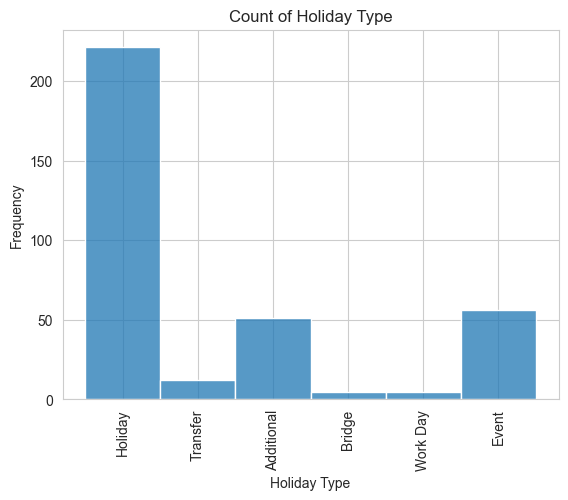

In [63]:
#Plotting frequency of holiday event types
sns.histplot(df_holidays_events, x="type")
plt.title("Count of Holiday Type")
plt.xlabel("Holiday Type")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [64]:
#Checking location of holiday events
df_holidays_events["locale_name"].value_counts()

locale_name
Ecuador                           174
Quito                              13
Riobamba                           12
Guaranda                           12
Latacunga                          12
Ambato                             12
Guayaquil                          11
Cuenca                              7
Ibarra                              7
Salinas                             6
Loja                                6
Santa Elena                         6
Santo Domingo de los Tsachilas      6
Quevedo                             6
Manta                               6
Esmeraldas                          6
Cotopaxi                            6
El Carmen                           6
Santo Domingo                       6
Machala                             6
Imbabura                            6
Puyo                                6
Libertad                            6
Cayambe                             6
Name: count, dtype: int64

In [65]:
#Checking how many holiday events took place on a different day than usual
df_holidays_events["transferred"].value_counts()

transferred
False    338
True      12
Name: count, dtype: int64

Next I will apply log transformation due to extreme outliers.

I will then begin to engineer some initial features for further EDA and later modelling.

### Log transformation

In [66]:
#Replacing 'unit_sales' 0 with NaN
df_ts['unit_sales'] = df_ts['unit_sales'].replace(0, np.nan)

#Infering data types
df_ts['unit_sales'] = df_ts['unit_sales'].infer_objects(copy=False)

#Interpolating missing values in place
df_ts['unit_sales'] = df_ts['unit_sales'].interpolate(method='linear')

#Checking if there are still NaNs
print("Remaining NaNs:", df_ts['unit_sales'].isnull().sum())

Remaining NaNs: 0


In [67]:
#Applying log1p
df_ts["unit_sales_log"] = np.log1p(df_ts["unit_sales"])

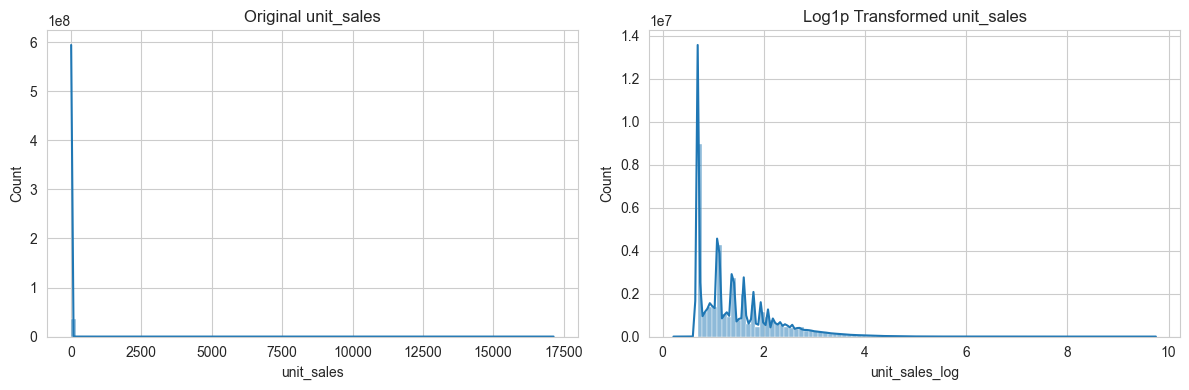

In [68]:
#Plotting before and after log transformation
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df_ts['unit_sales'], bins=100, ax=axs[0], kde=True)
axs[0].set_title('Original unit_sales')

sns.histplot(df_ts['unit_sales_log'], bins=100, ax=axs[1], kde=True)
axs[1].set_title('Log1p Transformed unit_sales')

plt.tight_layout()
plt.show()

### Feature engineering

In [69]:
#Creating 'is_outlier' binary flag for later modeling
outlier_threshold = df_ts["unit_sales"].quantile(0.99)
df_ts["is_outlier"] = (df_ts["unit_sales"] > outlier_threshold)

In [70]:
#Creating additional time features for EDA and modelling
df_ts["year"] = df_ts["date"].dt.year
df_ts["month"] = df_ts["date"].dt.month
df_ts["day"] = df_ts["date"].dt.day
df_ts["day_of_week"] = df_ts["date"].dt.dayofweek

In [71]:
#Creating rolling average of unit sales
df_ts["unit_sales_7d_avg"] = df_ts.groupby(["item_nbr", "store_nbr"])["unit_sales"].transform(lambda x: x.rolling(window=7).mean())

In [72]:
#Rechecking datatypes
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35069356 entries, 0 to 35069355
Data columns (total 12 columns):
 #   Column             Dtype         
---  ------             -----         
 0   store_nbr          int64         
 1   item_nbr           int64         
 2   date               datetime64[ns]
 3   unit_sales         float64       
 4   onpromotion        float64       
 5   unit_sales_log     float64       
 6   is_outlier         bool          
 7   year               int32         
 8   month              int32         
 9   day                int32         
 10  day_of_week        int32         
 11  unit_sales_7d_avg  float64       
dtypes: bool(1), datetime64[ns](1), float64(4), int32(4), int64(2)
memory usage: 2.4 GB


#### Checkpoint

In [73]:
#Saving a checkpoint after feature engineering
df_ts.to_parquet("/Users/dan/PycharmProjects/Masterschool/TimeSeriesRetailForecast/data/df_ts_checkpoint3.parquet")
print("Checkpoint 3 saved successfully!")

Checkpoint 3 saved successfully!


In [3]:
df_ts = pd.read_parquet("/Users/dan/PycharmProjects/Masterschool/TimeSeriesRetailForecast//data/df_ts_checkpoint3.parquet")

### Joining additional df

Next I will join 1) holiday events 2) oil price 3) product family and store type features into the train df for further analysis

In [74]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [75]:
df_holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [76]:
#Setting date as index so that joining is more efficient
df_ts.set_index('date', inplace=True)
df_holidays_events.set_index('date', inplace=True)
df_oil.set_index('date', inplace=True)

#### Holiday events

In [77]:
#Filtering relevant holiday event types
valid_types = ["Holiday", "Transfer", "Bridge", "Additional"]
holidays_filtered = df_holidays_events[df_holidays_events["type"].isin(valid_types)].copy()

In [78]:
#Dropping transferred holidays (we keep Transfer instead)
holidays_filtered = holidays_filtered[~holidays_filtered["transferred"]]

In [79]:
#Creating a flag per date
holidays_filtered["is_holiday"] = 1

In [80]:
#Creating a holiday flag dataframe
holiday_flags = pd.DataFrame({
    'date': holidays_filtered.index,
    'is_holiday': holidays_filtered['is_holiday']
})

In [81]:
#Removing duplicates, keeping only one entry per date if multiple holidays fall on the same day
holiday_flags = holiday_flags.drop_duplicates(subset=['date'])

In [82]:
#Checking newly created holiday dataframe
holiday_flags.head()

,date,is_holiday
date,,
2012-03-02,2012-03-02,1
2012-04-01,2012-04-01,1
2012-04-12,2012-04-12,1
2012-04-14,2012-04-14,1
2012-04-21,2012-04-21,1


In [83]:
#Dropping date column as it is duplicate info
holiday_flags = holiday_flags.drop(columns=['date'])

In [84]:
#Joining holiday flags with the main dataframe (df_ts)
df_ts = df_ts.join(holiday_flags['is_holiday'], how='left')

In [85]:
#Filling nulls with 0 to represent no holiday
df_ts["is_holiday"] = df_ts["is_holiday"].fillna(0).astype(int)

#### Oil

In [86]:
df_oil.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


In [87]:
#Getting full daterange from df_ts before joining
full_date_range = pd.date_range(start=df_ts.index.min(), end=df_ts.index.max(), freq='D')

In [88]:
#Reindexing oil to fill missing dates before joining
df_oil = df_oil.reindex(full_date_range)
df_oil.index.name = 'date'

In [89]:
#Filling nulls using forward and backward fill
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].ffill().bfill()

In [90]:
#Joining oil prices with the main dataframe (df_ts)
df_ts = df_ts.join(df_oil, how='left')

#### Items

In [91]:
df_items_top.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
5,105574,GROCERY I,1045,0


In [92]:
#Keeping only relevant columns before joining
df_items_top = df_items_top[["item_nbr", "family"]]

In [93]:
#Making sure there are no duplicate item_nbrs (to avoid unexpected row expansion)
assert df_items_top["item_nbr"].is_unique

In [94]:
#Joining top items to df_ts
df_ts = df_ts.join(df_items_top.set_index("item_nbr"), on="item_nbr")

In [95]:
#Checking df_ts dataframe before finalising for modeling
df_ts.head()

,store_nbr,item_nbr,unit_sales,onpromotion,unit_sales_log,is_outlier,year,month,day,day_of_week,unit_sales_7d_avg,is_holiday,dcoilwtico,family
date,,,,,,,,,,,,,,
2013-01-02,24,105574,12.00,0.00,2.56,False,2013,1,2,2,NaN,0,93.14,GROCERY I
2013-01-03,24,105574,1.00,0.00,0.69,False,2013,1,3,3,NaN,0,92.97,GROCERY I
2013-01-04,24,105574,3.00,0.00,1.39,False,2013,1,4,4,NaN,0,93.12,GROCERY I
2013-01-05,24,105574,4.00,0.00,1.61,False,2013,1,5,5,NaN,0,93.12,GROCERY I
2013-01-06,24,105574,7.00,0.00,2.08,False,2013,1,6,6,NaN,0,93.12,GROCERY I


In [96]:
#Checking mid-points and variance for discrepancies
df_ts.describe()

,store_nbr,item_nbr,unit_sales,onpromotion,unit_sales_log,year,month,day,day_of_week,unit_sales_7d_avg,is_holiday,dcoilwtico
count,"35,069,356.00","35,069,356.00","35,069,356.00","14,745,768.00","35,069,356.00","35,069,356.00","35,069,356.00","35,069,356.00","35,069,356.00","34,944,628.00","35,069,356.00","35,069,356.00"
mean,32.03,"1,154,136.95",5.57,0.05,1.43,"2,014.84",6.22,15.66,3.00,5.57,0.11,67.89
std,7.40,"618,370.35",24.40,0.21,0.76,1.34,3.39,8.79,2.00,22.72,0.32,25.67
min,24.00,"96,995.00",0.24,0.00,0.21,"2,013.00",1.00,1.00,0.00,0.33,0.00,26.19
25%,27.00,"627,263.00",1.14,0.00,0.76,"2,014.00",3.00,8.00,1.00,1.57,0.00,46.37
50%,30.00,"1,136,208.50",2.34,0.00,1.21,"2,015.00",6.00,16.00,3.00,2.70,0.00,53.41
75%,35.00,"1,909,409.00",5.00,0.00,1.79,"2,016.00",9.00,23.00,5.00,5.29,0.00,95.72
max,51.00,"2,127,114.00","17,146.00",1.00,9.75,"2,017.00",12.00,31.00,6.00,"10,049.34",1.00,110.62


#### Checkpoint

In [97]:
#Saving CSV after completed data prep
df_ts.to_csv("/Users/dan/PycharmProjects/Masterschool/TimeSeriesRetailForecast/data/prepared_ts_data.csv")

In [7]:
df_ts = pd.read_csv("/Users/dan/PycharmProjects/Masterschool/TimeSeriesRetailForecast/data/prepared_ts_data.csv", parse_dates=["date"], index_col="date")

### Time Series EDA

In [98]:
#Double check on data types
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35069356 entries, 2013-01-02 to 2017-08-15
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   store_nbr          int64  
 1   item_nbr           int64  
 2   unit_sales         float64
 3   onpromotion        float64
 4   unit_sales_log     float64
 5   is_outlier         bool   
 6   year               int32  
 7   month              int32  
 8   day                int32  
 9   day_of_week        int32  
 10  unit_sales_7d_avg  float64
 11  is_holiday         int64  
 12  dcoilwtico         float64
 13  family             object 
dtypes: bool(1), float64(5), int32(4), int64(3), object(1)
memory usage: 3.2+ GB


In [99]:
#Checking a portion of the dataframe
df_ts.tail()

,store_nbr,item_nbr,unit_sales,onpromotion,unit_sales_log,is_outlier,year,month,day,day_of_week,unit_sales_7d_avg,is_holiday,dcoilwtico,family
date,,,,,,,,,,,,,,
2017-08-11,51,2123791,1.00,NaN,0.69,False,2017,8,11,4,1.00,1,48.81,GROCERY I
2017-08-12,51,2123791,1.00,NaN,0.69,False,2017,8,12,5,1.00,0,48.81,GROCERY I
2017-08-13,51,2123791,1.00,NaN,0.69,False,2017,8,13,6,1.00,0,48.81,GROCERY I
2017-08-14,51,2123791,1.00,NaN,0.69,False,2017,8,14,0,1.00,0,47.59,GROCERY I
2017-08-15,51,2123791,1.00,0.00,0.69,False,2017,8,15,1,1.00,1,47.57,GROCERY I


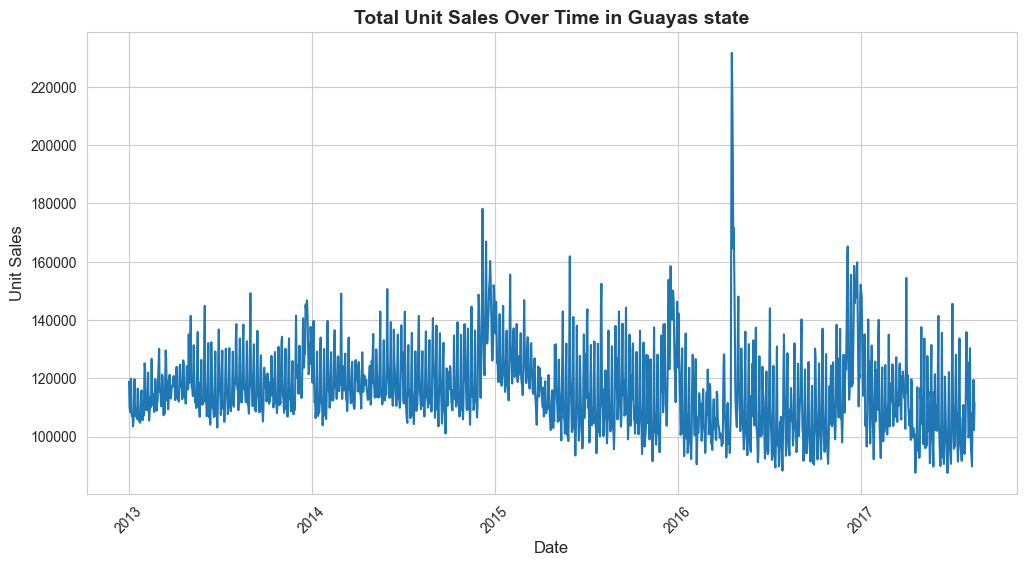

In [100]:
#Aggregating by sales
df_daily_sales = df_ts.groupby(df_ts.index).agg({"unit_sales": "sum"})

#Plotting unit_sales time-series
plt.figure(figsize=(12,6))
plt.plot(df_daily_sales.index, df_daily_sales["unit_sales"])
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Unit Sales', fontsize=12)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.show()

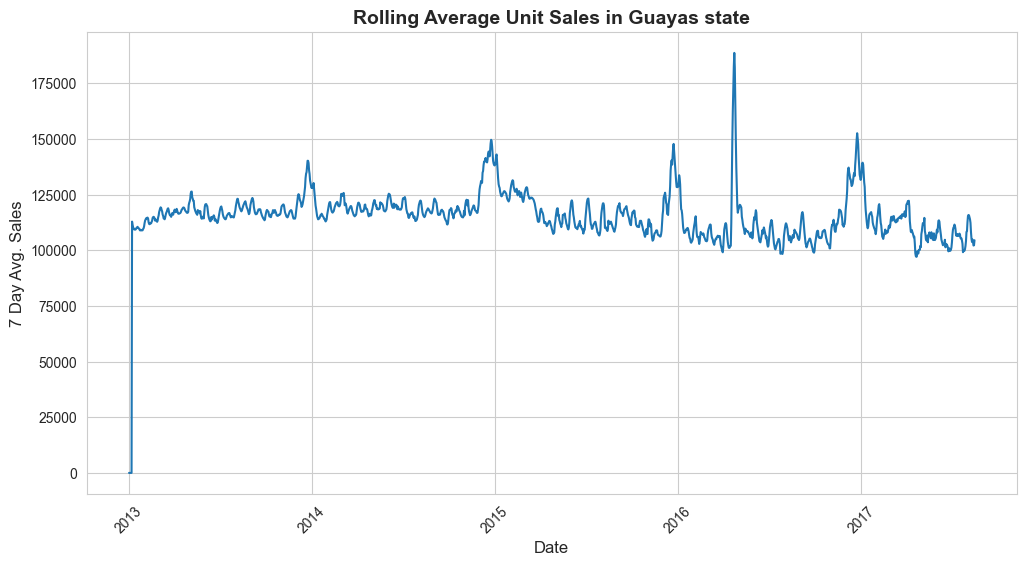

In [101]:
#Aggregating by sales
df_rolling_sales = df_ts.groupby(df_ts.index).agg({"unit_sales_7d_avg": "sum"})

#Plotting the 7 days rolling average time-series
plt.figure(figsize=(12,6))
plt.plot(df_rolling_sales.index, df_rolling_sales["unit_sales_7d_avg"])
plt.title('Rolling Average Unit Sales in Guayas state', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('7 Day Avg. Sales', fontsize=12)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.show()

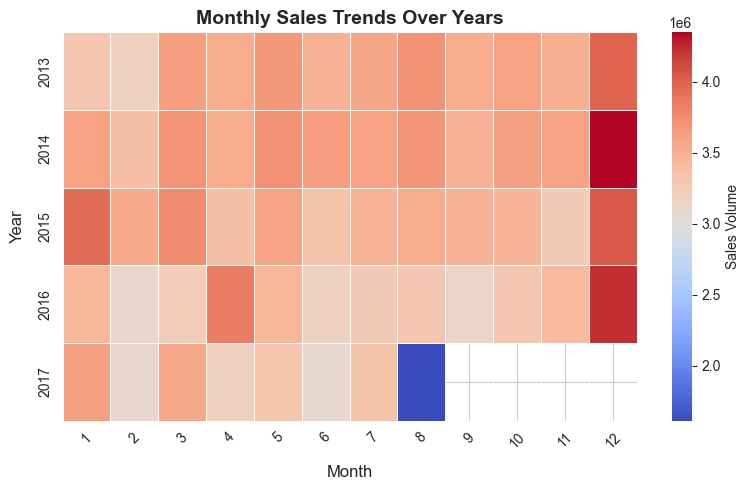

In [102]:
#Aggregating sales by year and month
sales_by_month = df_ts.groupby(['year', 'month'])['unit_sales'].sum().unstack()

#Plotting heatmap of sales by year and month
plt.figure(figsize=(8, 5))
sns.heatmap(
    sales_by_month,
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Sales Volume'}
)

#Customizing title and axes labels
plt.title('Monthly Sales Trends Over Years', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12, labelpad=10)
plt.ylabel('Year', fontsize=12, labelpad=10)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

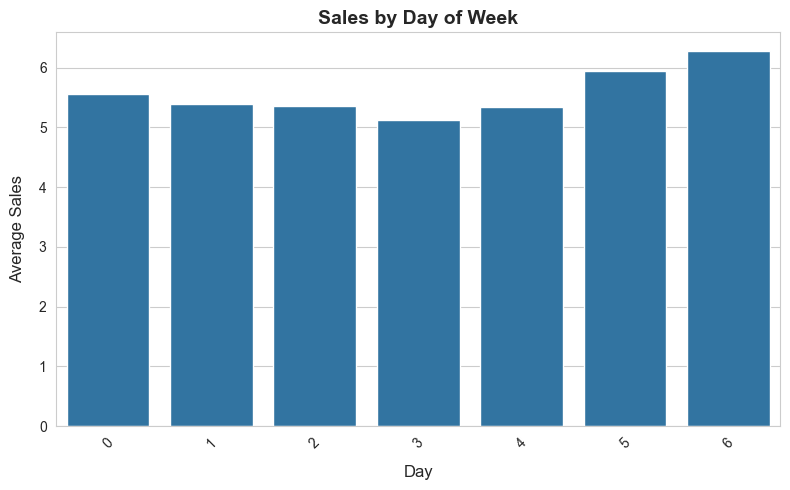

In [103]:
#Aggregatting sale by day of week
sales_by_dow = df_ts.groupby("day_of_week")["unit_sales"].mean().reset_index()

#Plotting barplot for sales by day of week
plt.figure(figsize=(8, 5))
sns.barplot(sales_by_dow, x="day_of_week", y="unit_sales")
plt.title('Sales by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day', fontsize=12, labelpad=10)
plt.ylabel('Average Sales', fontsize=12, labelpad=10)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

In [104]:
#Couting holiday occurrences
df_ts["is_holiday"].value_counts()

is_holiday
0    31057272
1     4012084
Name: count, dtype: int64

In [105]:
#Exploring correlations
values_to_compare = ["unit_sales", "unit_sales_7d_avg", "unit_sales_log", "onpromotion", "is_outlier", "year", "month", "day", "day_of_week", "is_holiday", "dcoilwtico"]
df_subset = df_ts[values_to_compare]
df_ts_corr = df_subset.corr()
df_ts_corr

,unit_sales,unit_sales_7d_avg,unit_sales_log,onpromotion,is_outlier,year,month,day,day_of_week,is_holiday,dcoilwtico
unit_sales,1.00,0.92,0.40,0.06,0.41,-0.01,0.00,-0.00,0.01,0.00,0.00
unit_sales_7d_avg,0.92,1.00,0.37,0.07,0.37,-0.01,0.00,-0.00,0.00,0.00,0.00
unit_sales_log,0.40,0.37,1.00,0.09,0.39,-0.04,0.01,-0.01,0.03,0.01,0.03
onpromotion,0.06,0.07,0.09,1.00,0.05,0.17,0.03,0.00,-0.00,0.01,-0.12
is_outlier,0.41,0.37,0.39,0.05,1.00,-0.01,0.00,-0.00,0.01,0.00,0.01
year,-0.01,-0.01,-0.04,0.17,-0.01,1.00,-0.15,-0.01,0.00,-0.01,-0.83
month,0.00,0.00,0.01,0.03,0.00,-0.15,1.00,0.01,-0.00,0.16,0.01
day,-0.00,-0.00,-0.01,0.00,-0.00,-0.01,0.01,1.00,0.00,-0.07,-0.00
day_of_week,0.01,0.00,0.03,-0.00,0.01,0.00,-0.00,0.00,1.00,-0.01,0.00
is_holiday,0.00,0.00,0.01,0.01,0.00,-0.01,0.16,-0.07,-0.01,1.00,-0.01


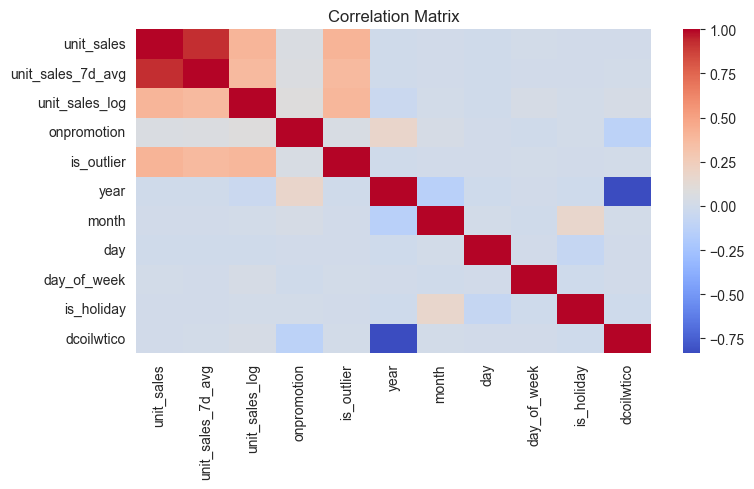

In [106]:
#Plotting correlations for visual comparison of target (unit_sales) vs features
plt.figure(figsize=(8, 5))
sns.heatmap(df_ts_corr, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

No extreme correlations to note so for now I will keep with these features.

I will now apply forecast modelling, testing a variety of algorithms, followed by hyperparameter tuning.